In [1]:
import pyaudio
import wave
# record audio commands

CHUNK = 256
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 22050
RECORD_SECONDS = 2
for i in range(1,20):
    WAVE_OUTPUT_FILENAME = "Dataset\\decrease_volume\\"+str(i)+".wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()


* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording


In [2]:
import os
import librosa
import random
from pydub import AudioSegment
import numpy as np


C:\Users\Farheen\.conda\envs\py383\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Farheen\.conda\envs\py383\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Farheen\.conda\envs\py383\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or av

In [3]:
'''We can take random 1-second crops from the recorded 20 samples and append it with 1-second silence. 
This is will provide us with a significant amount of data for each class.'''
#Cropping the 2 second audio to effective one second

for files in os.listdir('Dataset'):
    try:
        count = 21
        for comm in os.listdir('Dataset\\'+str(files)):
            sound = AudioSegment.from_file('Dataset\\'+str(files)+'\\'+str(comm))
            halfway_point = len(sound) // 2
            for _ in range(10):
                val = random.randint(1, halfway_point)
                crop_audio = sound[val:val+halfway_point]
                crop_audio.export('Dataset\\test.wav',format='wav')
                data, sf = librosa.load('Dataset\\test.wav')
                new_crop = np.pad(data,(0,22026),'constant') # Pad data so that the duration matches (2 Sec)
                librosa.output.write_wav('Dataset\\'+str(files)+'\\'+str(count)+'.wav',new_crop,sf)
                count += 1
    except:
        pass
print("* done")

* done


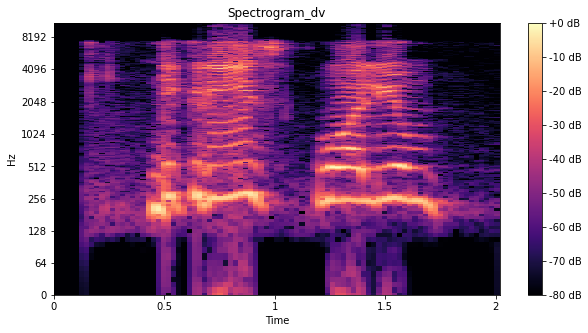

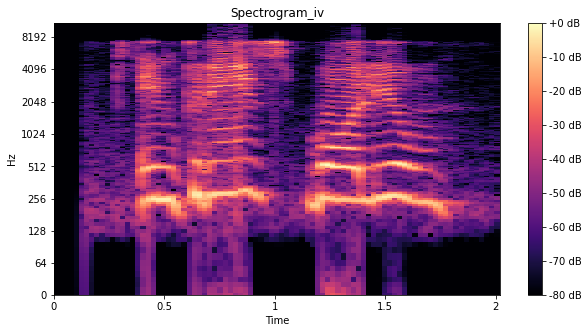

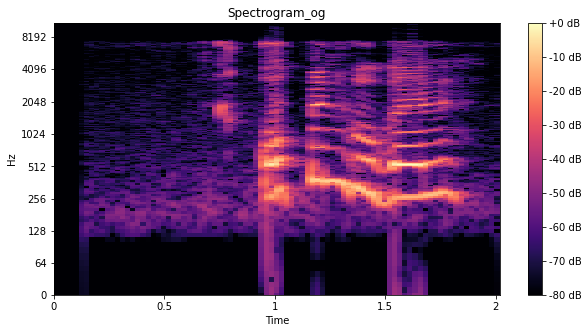

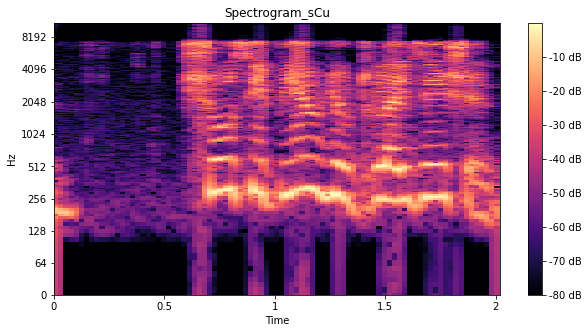

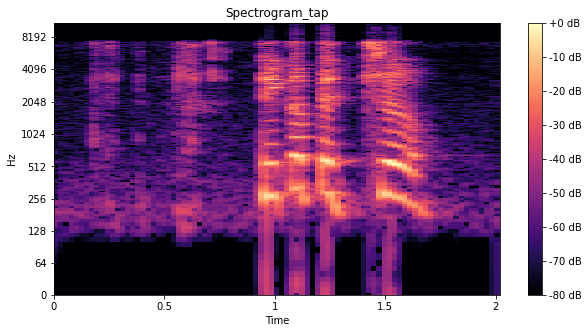

In [4]:
'''The recorded voice commands are stored as .wav files and if we can get the spectrogram of the audio file, 
we can treat it as an image and feed it into a CNN to classify the audio using librosa library.
In order to generate the spectrogram, we take the Short-time Fourier transform of the audio data. 
Fourier transform is used to convert a signal from the time domain to the frequency domain, 
we do this in order to know how much the signal is varying. '''
#generate spectograms for all the commands

import matplotlib.pyplot as plt
import librosa.display


def generate_spect(path, title):
    data, sr = librosa.load(path)
    D = np.abs(librosa.stft(data))
    plt.figure(figsize=(10,5))
    librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='log', x_axis='time')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
#spectrogram to decrease volume    
generate_spect(path="Dataset\\decrease_volume\\1.wav", title="Spectrogram_dv")
#spectrogram to increase volume    
generate_spect(path="Dataset\\increase_volume\\1.wav", title="Spectrogram_iv")
#spectrogram to open google    
generate_spect(path="Dataset\\open_google\\1.wav", title="Spectrogram_og")
#spectrogram to show cpu utilization   
generate_spect(path="Dataset\\show_CPU_utilization\\1.wav", title="Spectrogram_sCu")
#spectrogram to take picture   
generate_spect(path="Dataset\\Take_a_picture\\1.wav", title="Spectrogram_tap")


In [5]:
'''We can now generate the spectrogram  each of the audio samples & dump it into a numpy array'''
#save all 110* 5 files in npy format

peak_features = []
peak_labels = []
count = 0

for dirc in sorted(os.listdir('Dataset')):
    try:
        print('Reading ' + str(dirc))
        for files in os.listdir('Dataset\\' + str(dirc)):
            data, sf = librosa.load('Dataset\\' + str(dirc) + '\\' + str(files))
            D = np.abs(librosa.stft(data))

            if (D.shape != (1025, 87)):
                D = np.pad(D, ((0, 0), (0, 1)), 'constant')

            peak_features.append(D)
            peak_labels.append(count)
    except:
            pass
    count += 1
    

peak_features = np.array(peak_features)
peak_labels = np.array(peak_labels)

print(peak_features.shape)
print(peak_labels.shape)

np.save('Dataset\\command_spect.npy', peak_features)
np.save('Dataset\\command_spect_labels.npy', peak_labels)


Reading command_spect.npy
Reading command_spect_labels.npy
Reading decrease_volume
Reading increase_volume
Reading open_google
Reading show_CPU_utilization
Reading take_a_picture
Reading test.wav
(550, 1025, 87)
(550,)


In [6]:
'''Before building the model, we shuffle and split the data into training and testing sets. We also convert the labels into one hot encodings '''
#shuffle_split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
np_image2= np.load('Dataset\\command_spect_labels.npy')#load label data
np_image= np.load('Dataset\\command_spect.npy')#load feature data

np_image2= np_image2.reshape(-1,1)#label data reshape
y_data = enc.fit_transform(np_image2).toarray()#label data
x_data, y_data = shuffle(np_image, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2,stratify=y_data,random_state=42)

X_train = X_train.reshape((-1,1025,87,1))
X_test = X_test.reshape((-1,1025,87,1))


In [7]:

#We can now start building the Convolutional Neural Network and to do that we will be using TF 2.0 as our framework

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Model

# Create training and testing datasets from tensors
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(20)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(20)

# CNN Model
class Command(Model):
    def __init__(self):
        super(Command,self).__init__()
        self.conv1= Conv2D(32,3,padding='same',activation='relu')
        self.pool1 = MaxPooling2D((2,2))
        self.conv2= Conv2D(64,3,padding='same',activation='relu')
        self.pool2 = MaxPooling2D((2,2))
        self.conv3= Conv2D(128,3,padding='same',activation='relu')
        self.flatten = Flatten()
        self.fc1=Dense(256, activation='relu')
        self.fc2=Dropout(0.4)
        self.fc3=Dense(38, activation='relu')
        self.fc4=Dropout(0.4)
        self.fc5=Dense(5, activation='softmax')
    def call(self,x):
        x=self.conv1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x=self.conv3(x)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)
        x=self.fc5(x)
        return x


In [8]:
#train our model for 10 epochs, we evaluate our model on cross-entropy loss and use RMSProp as our optimizer

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')


In [10]:
model= Command()

In [11]:
EPOCHS = 5
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    

Epoch 1, Loss: 4.752339839935303, Accuracy: 72.04545593261719, Test Loss: 0.9765572547912598, Test Accuracy: 89.09090423583984
Epoch 2, Loss: 0.04033200442790985, Accuracy: 99.54545593261719, Test Loss: 0.32541075348854065, Test Accuracy: 94.54545593261719
Epoch 3, Loss: 0.001724732923321426, Accuracy: 100.0, Test Loss: 0.33001840114593506, Test Accuracy: 94.54545593261719
Epoch 4, Loss: 0.0004519389185588807, Accuracy: 100.0, Test Loss: 0.3403618037700653, Test Accuracy: 94.54545593261719
Epoch 5, Loss: 0.00012530469393823296, Accuracy: 100.0, Test Loss: 0.35514816641807556, Test Accuracy: 94.54545593261719


In [12]:
tf.saved_model.save(model,"commands_model_spect")
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: commands_model_spect\assets
Saved model to disk


In [13]:
#increase volume
import osascript

def increase_vol():
    vol = osascript.osascript('get volume settings')
    cur_vol = int(vol[1].split(':')[1].split(',')[0])
    cur_vol = cur_vol + 20
    if(cur_vol > 100):
          cur_vol = 100
    osascript.osascript("set volume output volume "+str(cur_vol))

In [14]:
#decrease volume
import osascript

def decrease_vol():
    vol = osascript.osascript('get volume settings')
    cur_vol = int(vol[1].split(':')[1].split(',')[0])
    cur_vol = cur_vol - 20
    if(cur_vol < 0):
          cur_vol = 0
    osascript.osascript("set volume output volume "+str(cur_vol))

In [15]:
#find CPU Utilization
import os

def cpu_utilization():
    os.system('top')

In [16]:
#open google
import webbrowser

def open_google():
    webbrowser.open('http://google.com')

In [17]:
#take a picture
import cv2

def take_pic():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("take a picture") 
    img_counter = 0
    while True:
        ret, frame = cam.read()
        cv2.imshow("test", frame)
        if not ret:
            break
        k = cv2.waitKey(1)

        if k%256 == 27:
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1
    cam.release()

    cv2.destroyAllWindows()

In [19]:

#predict performance

import pyaudio
import wave
from keras.models import load_model
import librosa
import numpy as np
import warnings
import osascript
import webbrowser
import os
import cv2

warnings.filterwarnings(action='ignore',category=FutureWarning)

model_1=model
print('* model loaded')

CHUNK = 256
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 22050
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "test.wav"
print("* recording")

while(True):
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(data)
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    data, sf = librosa.load('test.wav')
    D = np.abs(librosa.stft(data))
    D = D.reshape((1,1025,87,1))
    output_1 = model_1.predict(D)
    class_pred = np.argmax(output_1)
    confidence = max(output_1[0])

    print(class_pred)
    print(confidence)


    os.remove('test.wav')

    if(class_pred == 0 and confidence > 0.99):
        print("* Decreasing Volume")
        decrease_vol()

    elif(class_pred == 1 and confidence > 0.99):
        increase_vol()

    elif(class_pred == 2 and confidence > 0.99):
        print("* Opening Google")
        open_google()

    elif(class_pred == 3 and confidence > 0.9999):
        print("* Showing CPU Utilization")
        cpu_utilization()

    elif(class_pred == 4 and confidence > 0.99):
        print("* Taking a picture")
        take_pic()
        

* model loaded
* recording
2
0.9997515
* Opening Google
3
0.20194644
4
0.22058952
4
0.20345148
3
0.20543985
3
0.2203811
4
0.24975523
3
0.23616007
3
0.700985
3
0.9885417
4
0.99998474
* Taking a picture


KeyboardInterrupt: 